In [94]:
import nibabel as nib
import numpy as np
import os
import pydicom
import scipy.ndimage
from pydicom.dataset import Dataset, FileDataset
import datetime
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import io

In [48]:
nifti_file_seg = '~/Downloads/066volume_010.nii.gz'
nifti_file = '~/Downloads/066volume_010_0000.nii.gz'
image_seg = nib.load(nifti_file_seg)
data = image_seg.get_fdata()
image = nib.load(nifti_file)

In [49]:
unique_values = np.unique(data)
print("Unique values in the NIfTI file:", unique_values)

Unique values in the NIfTI file: [0. 1. 2.]


In [50]:
# voxel_dims of prediction
voxel_dims = image_seg.header.get_zooms()
print(voxel_dims)

(0.907, 0.907, 0.8)


In [51]:
# voxel_dims of input nifti
voxel_dims = image.header.get_zooms()
print(voxel_dims)

(0.907, 0.907, 0.8)


In [52]:
def get_dicom_voxel_dims(dicom_dir):
    # Load a sample DICOM file to get the metadata
    dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    
    if not dicom_files:
        raise ValueError("No DICOM files found in the directory.")

    sample_dicom = dicom_files[0]

    # Extract pixel spacing and slice thickness
    pixel_spacing = sample_dicom.PixelSpacing  # [x, y]
    slice_thickness = sample_dicom.SliceThickness  # z

    voxel_dims = (pixel_spacing[0], pixel_spacing[1], slice_thickness)
    return voxel_dims

In [53]:
dicom_dir = '/Users/fabio22/Iwas/Xipe_Data/Unnamed_066/unnamed_10'
print(get_dicom_voxel_dims(dicom_dir))

('0.907', '0.907', '1.0')


In [60]:
def calculate_tumor_properties(data, voxel_dims, decimal_places=2, target_label=2):
    # Filter data to include only the target label
    labeled_data, num_features = scipy.ndimage.label(data == target_label)
    
    if num_features == 0:
        return f"No tumor with label {target_label} found."

    tumors_info = []
    for i in range(1, num_features + 1):
        tumor_voxels = np.where(labeled_data == i)
        
        width_voxels = np.max(tumor_voxels[0]) - np.min(tumor_voxels[0]) + 1
        height_voxels = np.max(tumor_voxels[1]) - np.min(tumor_voxels[1]) + 1
        length_voxels = np.max(tumor_voxels[2]) - np.min(tumor_voxels[2]) + 1

        # Convert to physical units and round
        width_mm = round(width_voxels * voxel_dims[0], decimal_places)
        height_mm = round(height_voxels * voxel_dims[1], decimal_places)
        length_mm = round(length_voxels * voxel_dims[2], decimal_places)

        volume_voxels = tumor_voxels[0].size
        volume_mm3 = round(volume_voxels * (voxel_dims[0] * voxel_dims[1] * voxel_dims[2]), decimal_places)

        density = round(volume_voxels / (width_voxels * height_voxels * length_voxels), decimal_places)

        tumors_info.append({
            "label": target_label,
            "region": i,
            "width (mm)": width_mm,
            "height (mm)": height_mm,
            "length (mm)": length_mm,
            "volume (cubic mm)": volume_mm3,
            "density": density
        })

    return tumors_info

In [62]:
voxel_dims = image_seg.header.get_zooms()
tumor_properties = calculate_tumor_properties(data, voxel_dims)
print(tumor_properties)

[{'label': 2, 'region': 1, 'width (mm)': 11.79, 'height (mm)': 9.98, 'length (mm)': 15.2, 'volume (cubic mm)': 663.38, 'density': 0.37}]


In [88]:
def generate_table_image(tumor_info):
    # Create a DataFrame from the tumor information
    df = pd.DataFrame(tumor_info)
    
    # Plot the table
    fig, ax = plt.subplots(figsize=(8, 2 + len(tumor_info) * 0.4))  # Adjust the figure size as needed
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Adjust the scaling as needed
    
    # Save the table as an image in memory
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    return np.array(img)

In [89]:
def create_dicom_report_with_table(tumor_info, output_file):
    # Create a new DICOM file dataset
    file_meta = pydicom.dataset.FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    file_meta.ImplementationClassUID = pydicom.uid.PYDICOM_IMPLEMENTATION_UID

    ds = FileDataset(output_file, {}, file_meta=file_meta, preamble=b'\0' * 128)
    
    # Set patient and study information
    ds.PatientName = "Test^Patient"
    ds.PatientID = "123456"
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()
    ds.Modality = "OT"  # Other
    ds.StudyDate = datetime.datetime.now().strftime('%Y%m%d')
    ds.StudyTime = datetime.datetime.now().strftime('%H%M%S')

    # Generate the table image
    table_image = generate_table_image(tumor_info)

    # Add the table image to the DICOM file
    ds.Rows, ds.Columns = table_image.shape[:2]
    ds.SamplesPerPixel = 3 if len(table_image.shape) == 3 else 1
    ds.PhotometricInterpretation = "RGB" if len(table_image.shape) == 3 else "MONOCHROME2"
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0
    ds.PixelData = table_image.tobytes()

    # Save the DICOM file
    ds.save_as(output_file)
    print(f"DICOM report saved to {output_file}")

DICOM report saved to tumor_report.dcm


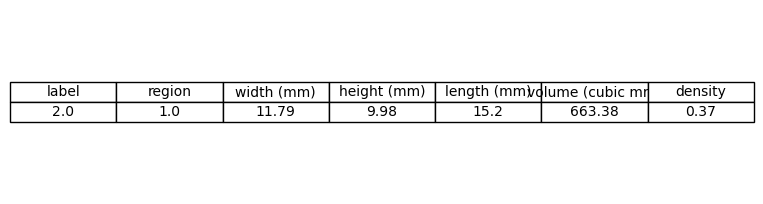

In [95]:
create_dicom_report_with_table(tumor_properties, 'tumor_report.dcm')

In [85]:
load_and_display_dicom_text('tumor_report.dcm')

DICOM Report Content:
PatientID: 123456
